# IMPORTING THE LIBRARIES 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statistics
import os

###############################################
from peakutils import indexes
from peakutils import baseline
from scipy.signal import find_peaks as fp
from scipy.signal import savgol_filter 
###############################################
from bokeh.plotting import figure , show
from pybaselines import whittaker as pl



from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# DATA ARRANGEMENT

In the main directory we can see that there are 8 subfolders. 

Each subfolder have almost 12 spectras per sample , the idea behind that would be , instead of having just one spectra per sample , and to just rely on one information , its always better have to multiple measurements per samples , and then this could be used for building the Calibration Model

Instead of having 12 different csv per samples , its always good to have a single dataframe -> This new dataframe will have 1st column as wavelength , and 2nd -13th column as Intensities 

In [3]:
def load_data(folder_path):
    # List to store DataFrames for intensity columns
    intensity_dfs = []

    # List to store CSV file names
    csv_file_names = []

    # Loop through each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            
            # Read CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Extract intensity column and store it in the list
            intensity_dfs.append(df.iloc[:, 1])  # Assuming intensity is in the second column
            
            # Store CSV file name
            csv_file_names.append(os.path.splitext(file_name)[0])

    # Read the wavelength column from the first CSV file
    wavelength_df = pd.read_csv(os.path.join(folder_path, os.listdir(folder_path)[1]), usecols=[0])

    # Concatenate wavelength column with intensity columns
    result_df = pd.concat([wavelength_df] + intensity_dfs, axis=1)

    # Rename the columns with CSV file names
    column_names = ['wavelength'] + [f'{csv_file_names[i]}' for i in range(len(intensity_dfs))]

    result_df.columns = column_names
    # result_df.reset_index(drop=True, inplace=True)

    return result_df

In [4]:
def baseline_correction(df):
    """
    Perform baseline correction on the intensity columns of the input DataFrame and create a new DataFrame with corrected values.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the wavelength and intensity columns.
        
    Returns:
        DataFrame: New DataFrame with baseline-corrected intensity columns and the same wavelength column as the input DataFrame.
    """
    # Copy the 'wavelength' column from the input DataFrame
    new_df = pd.DataFrame({'wavelength': df['wavelength']})
    
    # Perform baseline correction for each intensity column and add them to the new DataFrame
    for col in df.columns[1:]:  # Exclude the 'wavelength' column
        baseline, _ = pl.airpls(df[col],lam=0.1)
        corrected_values = df[col] - baseline
        new_df[col] = corrected_values
    
    return new_df

Loading the dataframe.

In [5]:
CR210LA_Raw_df = load_data('CR210LA')
###################################################
CR240LA_Raw_df = load_data('CR240LA')
###################################################
CR300LA_Raw_df = load_data('CR300LA')
###################################################
CR440Y_Raw_df = load_data('CR440Y')
###################################################
CR570CP_Raw_df = load_data('CR570CP')
###################################################
CR700Y_Raw_df = load_data('CR700Y')
###################################################
HR660Y_Raw_df = load_data('HR660Y')
# ###################################################
CR1000Y_Raw_df = load_data('CR1000Y')

In [6]:
# CR210LA_BaselineCorrected_df = baseline_correction(CR210LA_Raw_df)

# CR240LA_BaselineCorrected_df = baseline_correction(CR240LA_Raw_df)

# CR300LA_BaselineCorrected_df = baseline_correction(CR300LA_Raw_df)

# CR440Y_BaselineCorrected_df = baseline_correction(CR440Y_Raw_df)

# CR570CP_BaselineCorrected_df = baseline_correction(CR570CP_Raw_df)

# CR700Y_BaselineCorrected_df = baseline_correction(CR700Y_Raw_df)

# HR660Y_BaselineCorrected_df = baseline_correction(HR660Y_Raw_df)

# CR1000Y_BaselineCorrected_df = baseline_correction(CR1000Y_Raw_df)

######################################################

CR210LA_BaselineCorrected_df = CR210LA_Raw_df

CR240LA_BaselineCorrected_df = CR240LA_Raw_df

CR300LA_BaselineCorrected_df = CR300LA_Raw_df

CR440Y_BaselineCorrected_df = CR440Y_Raw_df

CR570CP_BaselineCorrected_df = CR570CP_Raw_df

CR700Y_BaselineCorrected_df = CR700Y_Raw_df

HR660Y_BaselineCorrected_df = HR660Y_Raw_df

CR1000Y_BaselineCorrected_df = CR1000Y_Raw_df

# Peak Selection and Data Trimming

The dataframe  which we have is very big ,it could be trimmed now according to the wavelength , by adjusting two parameters "Wavelength_Min" , "Wavelength_Max"

In [7]:
Wavelength_Min = 557.1
Wavelength_Max = 557.5

Element_name = 'Mo'

CR210LA_Select_df = CR210LA_BaselineCorrected_df[(CR210LA_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR210LA_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
CR240LA_Select_df = CR240LA_BaselineCorrected_df[(CR240LA_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR240LA_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
CR300LA_Select_df = CR300LA_BaselineCorrected_df[(CR300LA_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR300LA_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
CR440Y_Select_df = CR440Y_BaselineCorrected_df[(CR440Y_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR440Y_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
CR570CP_Select_df = CR570CP_BaselineCorrected_df[(CR570CP_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR570CP_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
CR700Y_Select_df = CR700Y_BaselineCorrected_df[(CR700Y_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR700Y_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
HR660Y_Select_df = HR660Y_BaselineCorrected_df[(HR660Y_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (HR660Y_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]
CR1000Y_Select_df = CR1000Y_BaselineCorrected_df[(CR1000Y_BaselineCorrected_df['wavelength'] >= Wavelength_Min) & (CR1000Y_BaselineCorrected_df['wavelength'] <= Wavelength_Max)]

CR210LA_Select_df


,wavelength,CR210LA_10,CR210LA_11,CR210LA_8,CR210LA_9,CR210LA_12,CR210LA_4,CR210LA_5,CR210LA_7,CR210LA_6,CR210LA_2,CR210LA_3,CR210LA_1
11313,557.100000,578.138292,523.426752,446.090729,485.845245,521.740329,459.509062,463.419625,418.401173,424.192959,444.725495,455.857436,421.926536
11314,557.133333,647.812405,569.323073,485.513743,512.833434,574.460056,503.649023,505.084576,455.397676,464.301920,477.955627,499.880219,450.997891
11315,557.166667,752.491942,635.879451,533.354347,552.712782,650.545383,560.617512,559.289655,502.051669,513.525315,523.366427,557.464031,497.544226
11316,557.200000,852.959636,698.019992,580.391813,590.666528,721.332926,619.591439,615.663677,549.510023,562.323710,572.436990,617.630869,553.152710
11317,557.233333,911.292107,731.536765,613.857628,612.373967,759.156990,663.938584,658.036708,584.655979,597.349752,610.683904,662.982093,599.977071
11318,557.266667,916.090710,730.015130,620.786420,613.683573,756.804474,676.704376,669.917048,594.136192,605.044786,623.292904,675.762783,619.647582
11319,557.300000,880.799976,703.705716,591.063095,599.968310,726.218270,644.464058,638.260539,567.424784,574.810105,598.445235,641.933719,597.256378
11320,557.333333,819.821561,663.501210,535.774340,576.968093,680.079284,580.049298,575.667532,515.027938,518.064492,546.604215,575.094809,543.646584
11321,557.366667,747.374639,619.729136,475.563181,550.272159,630.378337,508.126396,506.297201,456.931679,456.150739,488.276421,501.303831,481.268146
11322,557.400000,676.621915,579.445065,431.099940,524.597433,585.111076,453.396975,454.342849,413.149925,410.440102,443.998790,446.655061,432.607770


In [8]:
CR210LA_Select_Raw_df = CR210LA_Raw_df[(CR210LA_Raw_df['wavelength'] >= Wavelength_Min) & (CR210LA_Raw_df['wavelength'] <= Wavelength_Max)]
CR240LA_Select_Raw_df = CR240LA_Raw_df[(CR240LA_Raw_df['wavelength'] >= Wavelength_Min) & (CR240LA_Raw_df['wavelength'] <= Wavelength_Max)]
CR300LA_Select_Raw_df = CR300LA_Raw_df[(CR1000Y_Raw_df['wavelength'] >= Wavelength_Min) & (CR300LA_Raw_df['wavelength'] <= Wavelength_Max)]
CR440Y_Select_Raw_df = CR440Y_Raw_df[(CR440Y_Raw_df['wavelength'] >= Wavelength_Min) & (CR440Y_Raw_df['wavelength'] <= Wavelength_Max)]
CR570CP_Select_Raw_df = CR570CP_Raw_df[(CR570CP_Raw_df['wavelength'] >= Wavelength_Min) & (CR570CP_Raw_df['wavelength'] <= Wavelength_Max)]
CR700Y_Select_Raw_df = CR700Y_Raw_df[(CR700Y_Raw_df['wavelength'] >= Wavelength_Min) & (CR700Y_Raw_df['wavelength'] <= Wavelength_Max)]
HR660Y_Select_Raw_df = HR660Y_Raw_df[(HR660Y_Raw_df['wavelength'] >= Wavelength_Min) & (HR660Y_Raw_df['wavelength'] <= Wavelength_Max)]
CR1000Y_Select_Raw_df = CR1000Y_Raw_df[(CR1000Y_Raw_df['wavelength'] >= Wavelength_Min) & (CR1000Y_Raw_df['wavelength'] <= Wavelength_Max)]

CR210LA_Select_Raw_df

,wavelength,CR210LA_10,CR210LA_11,CR210LA_8,CR210LA_9,CR210LA_12,CR210LA_4,CR210LA_5,CR210LA_7,CR210LA_6,CR210LA_2,CR210LA_3,CR210LA_1
11313,557.100000,578.138292,523.426752,446.090729,485.845245,521.740329,459.509062,463.419625,418.401173,424.192959,444.725495,455.857436,421.926536
11314,557.133333,647.812405,569.323073,485.513743,512.833434,574.460056,503.649023,505.084576,455.397676,464.301920,477.955627,499.880219,450.997891
11315,557.166667,752.491942,635.879451,533.354347,552.712782,650.545383,560.617512,559.289655,502.051669,513.525315,523.366427,557.464031,497.544226
11316,557.200000,852.959636,698.019992,580.391813,590.666528,721.332926,619.591439,615.663677,549.510023,562.323710,572.436990,617.630869,553.152710
11317,557.233333,911.292107,731.536765,613.857628,612.373967,759.156990,663.938584,658.036708,584.655979,597.349752,610.683904,662.982093,599.977071
11318,557.266667,916.090710,730.015130,620.786420,613.683573,756.804474,676.704376,669.917048,594.136192,605.044786,623.292904,675.762783,619.647582
11319,557.300000,880.799976,703.705716,591.063095,599.968310,726.218270,644.464058,638.260539,567.424784,574.810105,598.445235,641.933719,597.256378
11320,557.333333,819.821561,663.501210,535.774340,576.968093,680.079284,580.049298,575.667532,515.027938,518.064492,546.604215,575.094809,543.646584
11321,557.366667,747.374639,619.729136,475.563181,550.272159,630.378337,508.126396,506.297201,456.931679,456.150739,488.276421,501.303831,481.268146
11322,557.400000,676.621915,579.445065,431.099940,524.597433,585.111076,453.396975,454.342849,413.149925,410.440102,443.998790,446.655061,432.607770


Lets plot a line plot ,to get a better picture 

In [9]:
Selected_df_Plot = figure(title = 'Selected Data Plot' , x_axis_label = 'Wavelength' , y_axis_label = 'Intensity')

Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_1 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_2 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_3 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_4 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_5 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_6 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_7 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_8 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_9 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_10 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_11 , line_width = 2, color ="red" )
Selected_df_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_12 , line_width = 2, color ="red" )

######################################################################################################################
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_1 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_2 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_3 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_4 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_5 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_6 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_7 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_8 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_9 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_10 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_11 , line_width = 2, color ="green" )
Selected_df_Plot.line(CR240LA_Select_df.wavelength,CR240LA_Select_df.CR240LA_12 , line_width = 2, color ="green" )

###############################################################################################################

Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_1 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_2 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_3 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_4 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_5 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_6 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_7 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_8 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_9 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_10 , line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_11, line_width = 2, color ="pink")
Selected_df_Plot.line(CR300LA_Select_df.wavelength,CR300LA_Select_df.CR300LA_12, line_width = 2, color ="pink")

######################################################################################################################

Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_1 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_2 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_3 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_4 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_5 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_6 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_7 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_8 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_9 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_10 , line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_11, line_width = 2, color ="yellow")
Selected_df_Plot.line(CR440Y_Select_df.wavelength,CR440Y_Select_df.CR440Y_12, line_width = 2, color ="yellow")

##############################################################################################################

Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_1 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_2 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_3 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_4 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_5 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_6 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_7 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_8 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_9 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_10 , line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_11, line_width = 2, color ="blue")
Selected_df_Plot.line(CR570CP_Select_df.wavelength,CR570CP_Select_df.CR570CP_12, line_width = 2, color ="blue")

###############################################################################################################

Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_1 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_2 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_3 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_4 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_5 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_6 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_7 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_8 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_9 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_10 , line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_11, line_width = 2, color ="orange")
Selected_df_Plot.line(CR700Y_Select_df.wavelength,CR700Y_Select_df.CR700Y_12, line_width = 2, color ="orange")


####################################################################################################################

Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_1 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_2 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_3 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_4 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_5 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_6 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_7 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_8 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_9 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_10 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_11 , line_width = 2, color ="brown")
Selected_df_Plot.line(HR660Y_Select_df.wavelength,HR660Y_Select_df.HR660Y_12 , line_width = 2, color ="brown")


##################################################################################################################

Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_1 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_2 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_3 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_4 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_5 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_6 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_7 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_8 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_9 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_10 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_11 , line_width = 2, color ="black")
Selected_df_Plot.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_12 , line_width = 2, color ="black")

###################################################################################################################

Selected_df_Plot.width = 500
Selected_df_Plot.height = 500
show(Selected_df_Plot)

# Data Preprocessing of the Spectra

The above plot eventhough a spectra , is still a Raw Spectra , which still has lot of Artifects , before proceeding for the Univariate Calibration , its important to Pre Process the Raw Spectra accordingly. Various Pre Processing Techniques could be used here :- 

1) Baseline Correction - Very Very little  background radiation is still present in the spectra, which corresponds to the spectral baseline and imposes difficulties for quantitative elemental analysis.

In [10]:
Baseline_Correction_Plot = figure(title = 'Baseline Correction' , x_axis_label = 'Wavelength' , y_axis_label = 'Intensity')

Baseline_Correction_Plot.line(CR210LA_Select_df.wavelength,CR210LA_Select_df.CR210LA_1 , line_width = 2, color ="green" )
Baseline_Correction_Plot.line(CR210LA_Select_Raw_df.wavelength,CR210LA_Select_Raw_df.CR210LA_1 , line_width =2 , color = "red")
Baseline_Correction_Plot.width = 600
Baseline_Correction_Plot.height = 500
show(Baseline_Correction_Plot)

2) Normalization - Its usually noticed that , for a measurement of a similar sample , the spectra obtained for them are quite different , but there could me many reasons for it , like laser energy fluctuations , material surface , even though is homegnous isnt same overall the surface

   For Instance , you could see the plot below , Though this are the plots from the same sample CR210LA , measured on 12 different Areas , its quite visible , for some  spectras , the peak heights or Intensities are not same.


In [11]:

Before_Normalization = figure(title = 'Before Normalization' , x_axis_label = 'Wavelength' , y_axis_label = 'Intensity')

Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_1 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_2 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_3 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_4 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_5 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_6 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_7 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_8 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_9 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_10 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_11 , line_width = 2, color ="red" )
Before_Normalization.line(CR1000Y_Select_df.wavelength,CR1000Y_Select_df.CR1000Y_12 , line_width = 2, color ="red" )


Before_Normalization.width = 600
Before_Normalization.height = 500
show(Before_Normalization)

Now , its important the understand this chnages in Peaks , are common not just to a single peaks , but to the entire spectra. If theres a change in intensity of a peak , its not just for a single peak , but it applies to the entire spectrum proportionally. 

Normalization by peak of an Matrix Element i.e Fe 238.20 (237.9 ~ 238.7) , 263.10 (262.9 ~ 263.4)

Lets try to focus now on analysis for peak of Matrix Element

In [12]:
Matrix_Wavelength_Min = 237.9
Matrix_Wavelength_Max = 238.7

CR210LA_Matrix_df = CR210LA_BaselineCorrected_df[(CR210LA_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR210LA_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
CR240LA_Matrix_df = CR240LA_BaselineCorrected_df[(CR240LA_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR240LA_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
CR300LA_Matrix_df = CR300LA_BaselineCorrected_df[(CR300LA_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR300LA_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
CR440Y_Matrix_df = CR440Y_BaselineCorrected_df[(CR440Y_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR440Y_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
CR570CP_Matrix_df = CR570CP_BaselineCorrected_df[(CR570CP_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR570CP_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
CR700Y_Matrix_df = CR700Y_BaselineCorrected_df[(CR700Y_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR700Y_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
HR660Y_Matrix_df = HR660Y_BaselineCorrected_df[(HR660Y_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (HR660Y_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]
CR1000Y_Matrix_df = CR1000Y_BaselineCorrected_df[(CR1000Y_BaselineCorrected_df['wavelength'] >= Matrix_Wavelength_Min) & (CR1000Y_BaselineCorrected_df['wavelength'] <= Matrix_Wavelength_Max)]

CR1000Y_Matrix_df

,wavelength,CR1000Y_3,CR1000Y_2,CR1000Y_1,CR1000Y_10,CR1000Y_5,CR1000Y_4,CR1000Y_11,CR1000Y_6,CR1000Y_7,CR1000Y_12,CR1000Y_9,CR1000Y_8
1738,237.933333,10083.398400,10816.250129,9231.056877,11922.070167,11119.740773,10831.194712,12302.316562,10979.447250,10819.661300,11916.881380,11424.653138,11194.777338
1739,237.966667,9842.171593,10632.854021,9076.634703,10317.760343,10850.822325,10582.835990,10622.280829,10233.021177,10023.825885,10261.246221,9913.280758,10300.509865
1740,238.000000,10848.372636,11718.008139,9845.474745,11041.037363,12151.316325,11806.803821,11441.201201,11056.557682,10907.981259,10993.508021,10481.631738,11253.230565
1741,238.033333,13292.088206,14195.066266,11911.068959,13951.887474,14864.492929,14445.088750,14523.146847,13438.638254,13418.018330,13961.517500,13144.670405,13861.765855
1742,238.066667,17254.674867,18082.527659,15547.425489,17949.311799,18730.461087,18335.313362,18583.816366,17128.829048,17244.866110,18031.952102,17084.832283,17643.061719
1743,238.100000,21929.043711,22611.291664,20038.729650,22013.187955,22972.997037,22695.598154,22493.958353,21515.377504,21732.644710,22155.560727,21449.058501,21892.349240
1744,238.133333,25898.510646,26471.856292,23990.012831,25400.737380,26461.602110,26319.000407,25649.238230,25435.351913,25696.429307,25571.240432,25273.290302,25566.641124
1745,238.166667,27909.188246,28500.360851,26153.995705,27429.787572,28197.134079,28138.314305,27556.151808,27721.259152,27950.124772,27580.872601,27575.174730,27632.097910
1746,238.200000,27764.942827,28478.646233,26257.935017,27688.351689,28017.626181,27982.628775,27882.152292,27945.254660,28074.304336,27768.610781,27803.191396,27719.992071
1747,238.233333,25665.721354,26542.688680,24394.027541,26246.034603,26074.611153,26016.664377,26581.590975,26313.304345,26306.505169,26221.743790,26173.756270,26031.535544


In [13]:
Selected_Matrix_Plot = figure(title = 'Selected Matrix Peak' , x_axis_label = 'Wavelength' , y_axis_label = 'Intensity')

Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_1 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_2 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_3 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_4 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_5 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_6 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_7 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_8 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_9 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_10 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_11 , line_width = 2, color ="red" )
Selected_Matrix_Plot.line(CR210LA_Matrix_df.wavelength,CR210LA_Matrix_df.CR210LA_12 , line_width = 2, color ="red" )

######################################################################################################################
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_1 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_2 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_3 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_4 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_5 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_6 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_7 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_8 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_9 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_10 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_11 , line_width = 2, color ="green" )
Selected_Matrix_Plot.line(CR240LA_Matrix_df.wavelength,CR240LA_Matrix_df.CR240LA_12 , line_width = 2, color ="green" )

###############################################################################################################

Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_1 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_2 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_3 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_4 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_5 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_6 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_7 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_8 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_9 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_10 , line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_11, line_width = 2, color ="pink")
Selected_Matrix_Plot.line(CR300LA_Matrix_df.wavelength,CR300LA_Matrix_df.CR300LA_12, line_width = 2, color ="pink")

######################################################################################################################

Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_1 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_2 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_3 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_4 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_5 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_6 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_7 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_8 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_9 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_10 , line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_11, line_width = 2, color ="yellow")
Selected_Matrix_Plot.line(CR440Y_Matrix_df.wavelength,CR440Y_Matrix_df.CR440Y_12, line_width = 2, color ="yellow")

##############################################################################################################

Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_1 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_2 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_3 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_4 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_5 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_6 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_7 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_8 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_9 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_10 , line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_11, line_width = 2, color ="blue")
Selected_Matrix_Plot.line(CR570CP_Matrix_df.wavelength,CR570CP_Matrix_df.CR570CP_12, line_width = 2, color ="blue")

###############################################################################################################

Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_1 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_2 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_3 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_4 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_5 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_6 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_7 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_8 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_9 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_10 , line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_11, line_width = 2, color ="orange")
Selected_Matrix_Plot.line(CR700Y_Matrix_df.wavelength,CR700Y_Matrix_df.CR700Y_12, line_width = 2, color ="orange")


####################################################################################################################

Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_1 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_2 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_3 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_4 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_5 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_6 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_7 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_8 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_9 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_10 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_11 , line_width = 2, color ="brown")
Selected_Matrix_Plot.line(HR660Y_Matrix_df.wavelength,HR660Y_Matrix_df.HR660Y_12 , line_width = 2, color ="brown")


##################################################################################################################

Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_1 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_2 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_3 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_4 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_5 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_6 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_7 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_8 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_9 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_10 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_11 , line_width = 2, color ="black")
Selected_Matrix_Plot.line(CR1000Y_Matrix_df.wavelength,CR1000Y_Matrix_df.CR1000Y_12 , line_width = 2, color ="black")

###################################################################################################################

Selected_Matrix_Plot.width = 600
Selected_Matrix_Plot.height = 500
show(Selected_Matrix_Plot)

In [14]:

def normalize_data(matrix_df, baseline_df):
    normalized_df = pd.DataFrame() #crete a df
    normalized_df['wavelength'] = baseline_df['wavelength'] #add first column as wavelength

    for sample_col in matrix_df.columns[1:]:
        peaks, _ = fp(matrix_df[sample_col], prominence=1000) #finds peak from matrix_df
        return_intensities = matrix_df[sample_col].iloc[peaks] #gets the intensity for that matrix peak
        # return_intensities = max(baseline_df[sample_col])      #Normalization by Maximum Intensity
        corresponding_col = sample_col
        normalized_df[sample_col] = baseline_df[corresponding_col] / return_intensities.values[0] #create a columns in normalized_df , by dividing the baseline_df by the intensities of the matrix peak 
    
    return normalized_df


In [15]:
# normalized_df = pd.DataFrame()
# normalized_df['wavelength'] = CR210LA_BaselineCorrected_df['wavelength']

# for sample_col in CR210LA_Matrix_df.columns[1:]:
#         peaks, _ = fp(CR210LA_Matrix_df[sample_col], prominence=1000 )
#         return_intensities = CR210LA_Matrix_df[sample_col].iloc[peaks]
#         correspondin_col = sample_col
#         print(return_intensities)
#         print(correspondin_col)
#         normalized_df[sample_col] = CR210LA_BaselineCorrected_df[correspondin_col] / return_intensities.values[0] 

# print (normalized_df)

In [16]:
CR210LA_Normalized_df = normalize_data (matrix_df=CR210LA_Matrix_df , baseline_df=CR210LA_BaselineCorrected_df)
CR240LA_Normalized_df = normalize_data (matrix_df=CR240LA_Matrix_df , baseline_df=CR240LA_BaselineCorrected_df)
CR300LA_Normalized_df = normalize_data (matrix_df=CR300LA_Matrix_df , baseline_df=CR300LA_BaselineCorrected_df)
CR440Y_Normalized_df = normalize_data (matrix_df=CR440Y_Matrix_df , baseline_df=CR440Y_BaselineCorrected_df)
CR570CP_Normalized_df = normalize_data (matrix_df=CR570CP_Matrix_df , baseline_df=CR570CP_BaselineCorrected_df)
CR700Y_Normalized_df = normalize_data (matrix_df=CR700Y_Matrix_df , baseline_df=CR700Y_BaselineCorrected_df)
HR660Y_Normalized_df = normalize_data (matrix_df=HR660Y_Matrix_df , baseline_df=HR660Y_BaselineCorrected_df)
CR1000Y_Normalized_df = normalize_data (matrix_df=CR1000Y_Matrix_df , baseline_df=CR1000Y_BaselineCorrected_df)
# print (CR210LA_Normalized_df.iloc[2493])

In [17]:
CR210LA_Processed_Select_df = CR210LA_Normalized_df[(CR210LA_Normalized_df['wavelength'] >= Wavelength_Min) & (CR210LA_Normalized_df['wavelength'] <= Wavelength_Max)]
CR240LA_Processed_Select_df = CR240LA_Normalized_df[(CR240LA_Normalized_df['wavelength'] >= Wavelength_Min) & (CR240LA_Normalized_df['wavelength'] <= Wavelength_Max)]
CR300LA_Processed_Select_df = CR300LA_Normalized_df[(CR300LA_Normalized_df['wavelength'] >= Wavelength_Min) & (CR300LA_Normalized_df['wavelength'] <= Wavelength_Max)]
CR440Y_Processed_Select_df = CR440Y_Normalized_df[(CR440Y_Normalized_df['wavelength'] >= Wavelength_Min) & (CR440Y_Normalized_df['wavelength'] <= Wavelength_Max)]
CR570CP_Processed_Select_df = CR570CP_Normalized_df[(CR570CP_Normalized_df['wavelength'] >= Wavelength_Min) & (CR570CP_Normalized_df['wavelength'] <= Wavelength_Max)]
CR700Y_Processed_Select_df = CR700Y_Normalized_df[(CR700Y_Normalized_df['wavelength'] >= Wavelength_Min) & (CR700Y_Normalized_df['wavelength'] <= Wavelength_Max)]
HR660Y_Processed_Select_df = HR660Y_Normalized_df[(HR660Y_Normalized_df['wavelength'] >= Wavelength_Min) & (HR660Y_Normalized_df['wavelength'] <= Wavelength_Max)]
CR1000Y_Processed_Select_df = CR1000Y_Normalized_df[(CR1000Y_Normalized_df['wavelength'] >= Wavelength_Min) & (CR1000Y_Normalized_df['wavelength'] <= Wavelength_Max)]

CR210LA_Processed_Select_df

,wavelength,CR210LA_10,CR210LA_11,CR210LA_8,CR210LA_9,CR210LA_12,CR210LA_4,CR210LA_5,CR210LA_7,CR210LA_6,CR210LA_2,CR210LA_3,CR210LA_1
11313,557.100000,0.028079,0.032684,0.033848,0.045357,0.030615,0.032341,0.031397,0.030636,0.031126,0.037896,0.029657,0.027761
11314,557.133333,0.031463,0.035550,0.036839,0.047877,0.033709,0.035447,0.034220,0.033345,0.034070,0.040728,0.032521,0.029673
11315,557.166667,0.036547,0.039706,0.040469,0.051600,0.038174,0.039457,0.037892,0.036761,0.037681,0.044598,0.036267,0.032736
11316,557.200000,0.041426,0.043586,0.044038,0.055143,0.042327,0.043608,0.041712,0.040236,0.041262,0.048779,0.040182,0.036395
11317,557.233333,0.044259,0.045679,0.046577,0.057170,0.044547,0.046729,0.044582,0.042809,0.043832,0.052038,0.043132,0.039475
11318,557.266667,0.044492,0.045584,0.047103,0.057292,0.044409,0.047627,0.045387,0.043503,0.044397,0.053113,0.043963,0.040770
11319,557.300000,0.042778,0.043941,0.044848,0.056012,0.042614,0.045358,0.043242,0.041548,0.042178,0.050995,0.041763,0.039296
11320,557.333333,0.039817,0.041431,0.040653,0.053864,0.039907,0.040825,0.039002,0.037711,0.038014,0.046578,0.037414,0.035769
11321,557.366667,0.036298,0.038698,0.036084,0.051372,0.036990,0.035763,0.034302,0.033457,0.033471,0.041608,0.032614,0.031665
11322,557.400000,0.032862,0.036182,0.032710,0.048975,0.034334,0.031911,0.030782,0.030251,0.030117,0.037835,0.029058,0.028463


In [18]:

After_Normalization = figure(title = 'After Normalization' , x_axis_label = 'Wavelength' , y_axis_label = 'Intensity')

After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_1 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_2 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_3 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_4 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_5 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_6 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_7 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_8 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_9 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_10 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_11 , line_width = 2, color ="red" )
After_Normalization.line(CR1000Y_Processed_Select_df.wavelength,CR1000Y_Processed_Select_df.CR1000Y_12 , line_width = 2, color ="red" )


After_Normalization.width = 600
After_Normalization.height = 500
show(After_Normalization)

# OUTLIER REMOVAL 

As you see from the Pic above , even after normalizing the Spectra , there are few variations in the Intensities , Before passing them to regression step , the important step would be to do Outlier Removal of the Intensities

In [19]:
def clean_intensities(processed_df, threshold):
    """
    Cleans intensities by removing outliers based on z-score method.

    Args:
    processed_df (DataFrame): DataFrame containing intensity data.
    threshold (float): Threshold for z-score.

    Returns:
    list: List containing cleaned intensities.
    """
    all_intensities = []

    for col in processed_df.columns[1:]:
        peak, _ = fp(processed_df[col], prominence=0.01)
        all_intensities.extend(processed_df[col].iloc[peak])

    mean_intensities = np.mean(all_intensities)
    std_intensities = np.std(all_intensities)
    z_scores = np.abs((all_intensities - mean_intensities) / std_intensities)

    cleaned_intensities = [intensity for intensity, z_score in zip(all_intensities, z_scores) if z_score < threshold]

    return cleaned_intensities


In [20]:
CR210LA_Selected_Intensities = clean_intensities(processed_df=CR210LA_Processed_Select_df , threshold=0.3)
CR240LA_Selected_Intensities = clean_intensities(processed_df=CR240LA_Processed_Select_df , threshold=0.3)
CR300LA_Selected_Intensities = clean_intensities(processed_df=CR300LA_Processed_Select_df , threshold=0.3)
CR440Y_Selected_Intensities = clean_intensities(processed_df=CR440Y_Processed_Select_df , threshold=0.3)
CR570CP_Selected_Intensities = clean_intensities(processed_df=CR570CP_Processed_Select_df , threshold=0.3)
CR700Y_Selected_Intensities = clean_intensities(processed_df=CR700Y_Processed_Select_df , threshold=0.3)
HR660Y_Selected_Intensities = clean_intensities(processed_df=HR660Y_Processed_Select_df , threshold=0.3)
CR1000Y_Selected_Intensities = clean_intensities(processed_df=CR1000Y_Processed_Select_df , threshold=0.3)

print(CR210LA_Selected_Intensities)
print(CR240LA_Selected_Intensities)
print(CR300LA_Selected_Intensities)
print(CR440Y_Selected_Intensities)
print(CR570CP_Selected_Intensities)
print(CR700Y_Selected_Intensities)
print(HR660Y_Selected_Intensities)
print(CR1000Y_Selected_Intensities)

[0.04567927161294198, 0.047103025949650115, 0.04762721800945878, 0.045387245206606565]
[0.046655058938194625, 0.04683762199893963, 0.04575116966079315]
[0.04526928806037099, 0.04594294604743229, 0.04640851366777845]
[0.04562758334143161]
[0.03889315212808619]
[0.04564442283664901, 0.045534435480676365, 0.044760549358532506]
[0.04336735821829801, 0.043416424839727734]
[]


In [21]:
# all_intensities = []

# for col in CR300LA_Processed_Select_df.columns[1:]:
#         peak, _ = fp(CR300LA_Processed_Select_df[col],prominence=0.5)
#         all_intensities.extend(CR300LA_Processed_Select_df[col].iloc[peak])
    
# print(all_intensities)
        
# mean_intensities = np.mean(all_intensities)
# std_intensities = np.std(all_intensities)
# z_scores = np.abs((all_intensities - mean_intensities) / std_intensities)

# cleaned_intensities = [intensity for intensity, z_score in zip(all_intensities, z_scores) if z_score < 2]
# print(cleaned_intensities)

# REGRESSION

At the last , now we have list we have selected intensities for each sample , also we have the concentration values per element of each sample , we can now do the regression

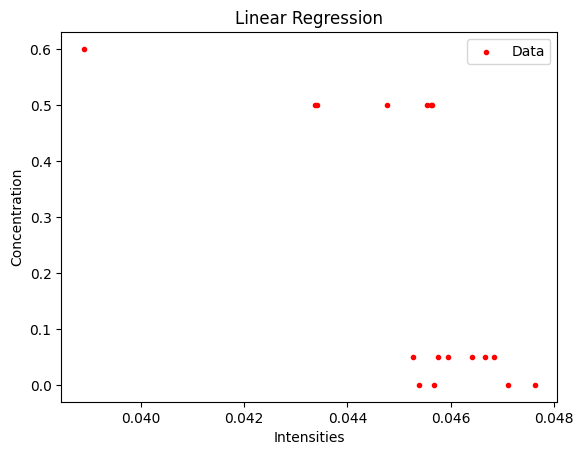

R^2 Score: -24576.79908724228
RMSE: 0.3036273490356986


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statistics import mean

# Given data
selected_intensities = {
    'CR210LA': (CR210LA_Selected_Intensities),
    'CR240LA': (CR240LA_Selected_Intensities),
    'CR300LA': (CR300LA_Selected_Intensities),
    'CR440Y':  (CR440Y_Selected_Intensities),
    'CR570CP': (CR570CP_Selected_Intensities),
    'CR700Y':  (CR700Y_Selected_Intensities),
    'HR660Y':  (HR660Y_Selected_Intensities),
    'CR1000Y': (CR1000Y_Selected_Intensities)
}

# Element data
elements = {
    'Element': ['Fe', 'Cu', 'Mo', 'Ni', 'Al', 'Si', 'Cr', 'Mn'],
    'CR210LA': [99.0, 0.10, 0.00, 0.05, 0.00, 0.20, 0.00, 0.30],
    'CR240LA': [99.0, 0.10, 0.05, 0.05, 0.10, 0.20, 0.05, 0.40],
    'CR300LA': [99.0, 0.10, 0.05, 0.10, 0.05, 0.30, 0.05, 0.60],
    'CR570CP': [97.0, 0.1,  0.5,  0.7,  0.5,  0.5,  0.5,  1.2],
     'CR440Y': [97.0, 0.1,  0.6,  0.1,  0.8,  0.4,  0.7,  1.2],
     'CR700Y': [96.0, 0.1,  0.5,  0.0,  0.5,  0.5,  0.5,  1.2],
     'HR660Y': [97.0, 0.1,  0.5,  0.1,  0.5,  0.5,  0.5,  1.2],
    'CR1000Y': [98.0, 0.1,  0.3,  0.0,  0.2,  0.2,  0.4,  1.2]
}

# Selecting an element
selected_element = Element_name

# Get y values based on selected element
y_values = [elements[key][elements['Element'].index(selected_element)] for key in selected_intensities]

x1 = selected_intensities['CR210LA']
x2 = selected_intensities['CR240LA'] 
x3 = selected_intensities['CR300LA'] 
x4 = selected_intensities['CR570CP'] 
x5 = selected_intensities['CR440Y'] 
x6 = selected_intensities['CR700Y'] 
x7 = selected_intensities['HR660Y'] 
x8 = selected_intensities['CR1000Y'] 

y1 = [y_values[0]] * len(selected_intensities['CR210LA'])
y2 = [y_values[1]] * len(selected_intensities['CR240LA'])
y3 = [y_values[2]] * len(selected_intensities['CR300LA'])
y4 = [y_values[3]] * len(selected_intensities['CR570CP'])
y5 = [y_values[4]] * len(selected_intensities['CR440Y'])
y6 = [y_values[5]] * len(selected_intensities['CR700Y'])
y7 = [y_values[6]] * len(selected_intensities['HR660Y'])
y8 = [y_values[7]] * len(selected_intensities['CR1000Y'])

X = np.concatenate([np.array(x1).reshape(-1, 1),
                    np.array(x2).reshape(-1, 1),
                    np.array(x3).reshape(-1, 1),
                    np.array(x4).reshape(-1, 1),
                    np.array(x5).reshape(-1, 1),
                    np.array(x6).reshape(-1, 1),
                    np.array(x7).reshape(-1, 1)])
                    #np.array(x8).reshape(-1, 1)])

y = np.concatenate([np.array(y1), 
                    np.array(y2),
                    np.array(y3),
                    np.array(y4),
                    np.array(y5),
                    np.array(y6),
                    np.array(y7)]) 
                    #np.array(y8)])



# Fit linear regression model
model = LinearRegression()
model.fit(X,y)

# # Predict y values
# y_pred = model.predict(X)

# Calculate R^2 score
r2 = r2_score(X, y)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(X,y))

# Plot scatter plot and regression line
plt.scatter(X, y, color='red',marker= '.' , label='Data')
plt.xlabel('Intensities')
plt.ylabel('Concentration')
plt.title('Linear Regression')
plt.legend()
plt.show()

print("R^2 Score:", r2)
print("RMSE:", rmse)